In [32]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from datetime import date
from matplotlib.animation import FuncAnimation

from Ps_library_temp import *
from Hamiltonian_library import *
from krotov_custom_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':20})
rc('text', usetex=True)

"""
Fidelity is the inner product, except that
 each individual eigenvector product is made to be phase insensitive before summing
"""
def fidelity_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    objective = objectives[0]
    overlap = np.sum(np.abs(np.asarray(fw_states_T))*np.abs(np.asarray(objective.target)))
    return overlap

def J_T_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    J_T = 1-fidelity_custom(fw_states_T,objectives)
    return J_T


# This chi_constructor assumes there is only one objective ....
def chis_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    chis = qt.zero_ket(system.N_points*system.internal_dims,dims=[[system.N_points,system.internal_dims],[1,1]])
    chis_ls = []
    fw_states_T =  fw_states_T[0]
    objective = objectives[0]

    for s in range(system.internal_dims):
        for n in range(system.N_points):
            eigenstate = qt.tensor(qt.basis(system.N_points,n),qt.basis(2,s))
            idx = system.internal_dims*n+s
            chis_n_s = fw_states_T.extract_states(idx)*objective.target.extract_states(idx)**2*eigenstate
            chis = chis + chis_n_s
            chis_ls.append(chis_n_s)
            
    return [chis]



In [34]:
system = Ps_system(N_atoms = 1,N_points = 100)
rabi0 = 2*np.pi*(400e-3)
chirp = 2*np.pi*(50e-3)
detuning = 0
direction = 1
pulse_duration = 10

laser_guess = {"label":"laser",
               "order":0,
               "scale":500,
               "rabi0" : rabi0,
                "detuning0": detuning,
                "chirp" : chirp,
                "pulse_duration" : pulse_duration,
                "unit_wavevector":direction,
                "start":0,"end":int(3*pulse_duration),
                "notch":0}

#system.init_MBdistribution()
system.init_distribution_flattop()
system.init_states_ground()

laser = laser_new(laser_guess)
system.create_composite()
system.set_Hamiltonian_MT_general_laser(laser)

velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state
velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(velocity_array) # move all initial velocity states 1 bin to the right
target_states = qt.tensor(target_velocity_states,excited_state).unit() # define target states to be in the excited state

# the probability that a given velocity bin is in the excited state
excited_states = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[system.N_points:system.N_points*2][i]*target_states))[0][0] for i in range(system.N_points)])

#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = 0.1
t_fall = 0.1
lambda_a = 0.01
lambda_b = 0.05
S = lambda t: krotov.shapes.flattop(t, t_start=0, t_stop=3*pulse_duration, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman')


def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)
plt.plot(laser.tlist,[S(t) for t in laser.tlist])
plt.show()
# result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
# plt.plot(system.velocity_bins,np.asarray(result.expect)[0:system.N_points,-1],label=r"$P_g$")
# plt.plot(system.velocity_bins,np.asarray(result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
# plt.legend()
# plt.show()
print(system.tensor_vel/c)

Quantum object: dims = [[201, 2], [201, 2]], shape = (402, 402), type = oper, isherm = True
Qobj data =
[[-0.0005    0.        0.       ...  0.        0.        0.      ]
 [ 0.       -0.0005    0.       ...  0.        0.        0.      ]
 [ 0.        0.       -0.000495 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.000495  0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.0005    0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.0005  ]]


In [5]:
old_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=300,
    continue_from = old_result,
    store_all_pulses=True    
)

(detuning) lambda_a = 0.01
(rabi0) lambda_b = 0.05
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.49e-02    0.00e+00   8.49e-02        n/a        n/a     6
101   8.29e-02    1.01e-03   8.40e-02  -1.94e-03  -9.31e-04    14
102   8.11e-02    9.88e-04   8.21e-02  -1.87e-03  -8.77e-04    13
103   7.93e-02    9.64e-04   8.03e-02  -1.79e-03  -8.28e-04    13
104   7.76e-02    9.40e-04   7.85e-02  -1.72e-03  -7.83e-04    13
105   7.59e-02    9.15e-04   7.68e-02  -1.66e-03  -7.41e-04    13
106   7.43e-02    8.90e-04   7.52e-02  -1.59e-03  -7.03e-04    13
107   7.28e-02    8.66e-04   7.37e-02  -1.53e-03  -6.67e-04    13
108   7.13e-02    8.41e-04   7.22e-02  -1.48e-03  -6.34e-04    14
109   6.99e-02    8.17e-04   7.07e-02  -1.42e-03  -6.03e-04    13
110   6.85e-02    7.94e-04   6.93e-02  -1.37e-03  -5.75e-04    13
111   6.72e-02    7.71e-04   6.80e-02  -1.32e-03  -5.48e-04    13
112   6.59e-02    7.49e-04   6.67e-02  -1.27e-03  -5.22e-04    13
113   6.47e-02    7.27e-0

In [6]:
opt_result.dump("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
old_result = opt_result

In [18]:
opt_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
opt_dynamics = opt_result.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)

fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel(r"$\Omega(t)$ [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist[:-1],H[1][1][:-1]*1e3/(2*np.pi),label=r"$\Delta_L(t)$",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

detuning = opt_result.optimized_controls[0]*1e3/(2*np.pi)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel(r"$\Omega(t)$ [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist[:-2],detuning[:-2],label=r"$\Delta_L(t)$",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for excitation",y=1.02)
#plt.savefig("figures/thesis_draft/excitation.svg",bbox_inches="tight")
plt.show()


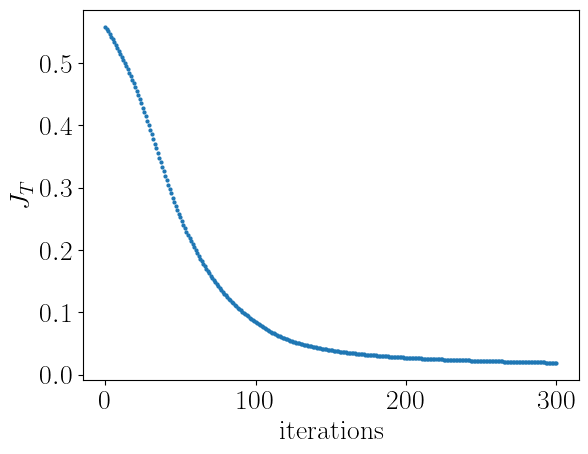

In [31]:
opt_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
plt.plot(opt_result.iters,opt_result.info_vals,'.',markersize=4)
plt.xlabel("iterations")
plt.ylabel(r"$J_T$")
plt.savefig("figures/thesis_draft/krotov_excitatation_JT.svg",bbox_inches="tight")
plt.show()

In [21]:
opt_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
N_pulses = len(opt_result.all_pulses)
iters = [0,20,50,100,300]
all_detunings = [opt_result.all_pulses[i][0] for i in iters]
all_envelopes = [opt_result.all_pulses[i][2] for i in iters]
all_envelopes_useless = [opt_result.all_pulses[i][1] for i in iters]
N_figures = len(all_detunings)
fig,[ax_env,ax_det,ax_pop] = plt.subplots(3,N_figures,figsize=(22,14))

J_Ts = [opt_result.info_vals[i] for i in iters]
i = 0
for (detuning,envelope,envelope_useless) in zip(all_detunings,all_envelopes,all_envelopes_useless):
    ax_det[i].plot(opt_result.tlist,krotov.conversions.pulse_onto_tlist(detuning*1e3/(2*np.pi)))
    ax_det[i].set_xlabel("time [ps]")
    ax_det[i].set_ylabel(r"$\Delta(t)$ [GHz]")
    ax_env[i].plot(opt_result.tlist,krotov.conversions.pulse_onto_tlist(envelope*1e3/(2*np.pi)))
    ax_env[i].set_title("iter:{}, J_T:{:.3f}".format(iters[i],J_Ts[i]))
    ax_env[i].set_xlabel("time [ps]")
    ax_env[i].set_ylabel(r"$\Omega(t)$ [GHz]")

    detunings = krotov.conversions.pulse_onto_tlist(detuning)
    envelopes = krotov.conversions.pulse_onto_tlist(envelope)
    envelopes_useless = krotov.conversions.pulse_onto_tlist(envelope_useless)
    objectives = opt_result.objectives_with_controls((detunings,envelopes_useless,envelopes))
    dynamics = objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
    ax_pop[i].plot(system.velocity_bins,np.asarray(unopt_result.expect)[0:system.N_points,0],ls="dashed",color="black")
    ax_pop[i].plot(system.velocity_bins[10:-10], np.asarray(dynamics.expect)[10+system.N_points:system.N_points*2-10,-1])
    ax_pop[i].set_xlabel("velocity [cm/ps]")
    ax_pop[i].set_ylabel(r"$P_e(t_f)$")
    ax_pop[i].set_ylim(-0.0001,0.006)
    i += 1
fig.tight_layout()
#plt.savefig("figures/thesis_draft/krotov_evolution_excitation.svg",bbox_inches="tight")
plt.show()

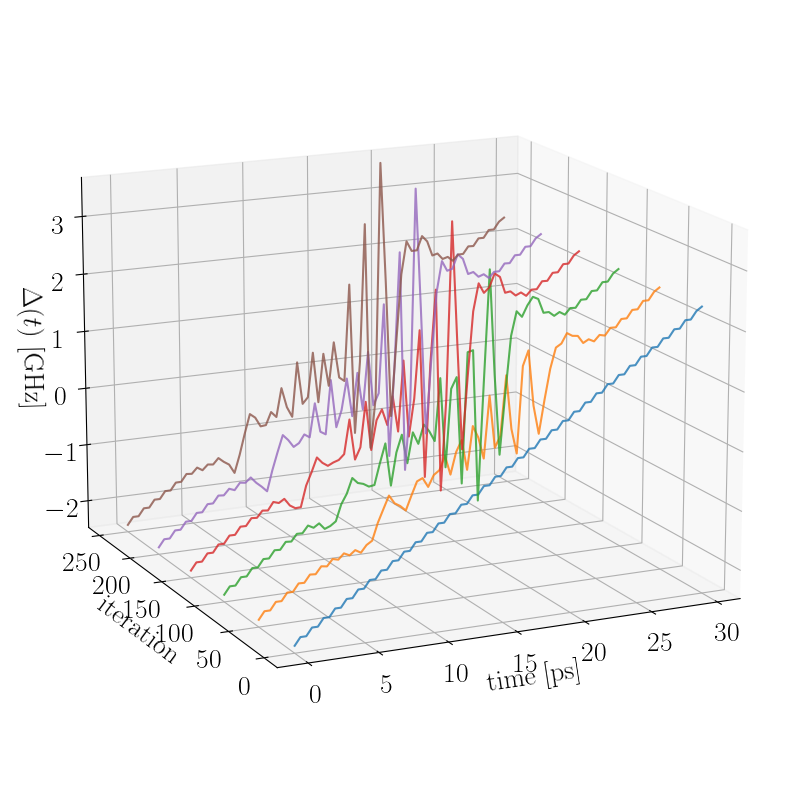

In [66]:
opt_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
ax = plt.figure(figsize=(10,10)).add_subplot(projection="3d")
N_pulses = len(opt_result.all_pulses)
iters = [i for i in range(0,300,50)]
all_detunings = [opt_result.all_pulses[i][0] for i in range(N_pulses)]
all_envelopes = [opt_result.all_pulses[i][2] for i in range(N_pulses)]
all_envelopes_useless = [opt_result.all_pulses[i][1] for i in range(N_pulses)]

for i in iters:    
    # detunings = krotov.conversions.pulse_onto_tlist(all_detunings[i])
    # envelopes = krotov.conversions.pulse_onto_tlist(all_envelopes[i])
    # envelopes_useless = krotov.conversions.pulse_onto_tlist(all_envelopes_useless[i])
    # objectives = opt_result.objectives_with_controls((detunings,envelopes_useless,envelopes))
    # dynamics = objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
    
    ax.plot(opt_result.tlist[:-1],ys=all_detunings[i],zs=i,zdir='y',alpha=0.8)
    ax.set_xlabel("time [ps]")
    ax.set_ylabel("iteration")
    ax.set_zlabel(r"$\Delta(t)$ [GHz]")
ax.view_init(elev=15,azim=-115,roll=0)


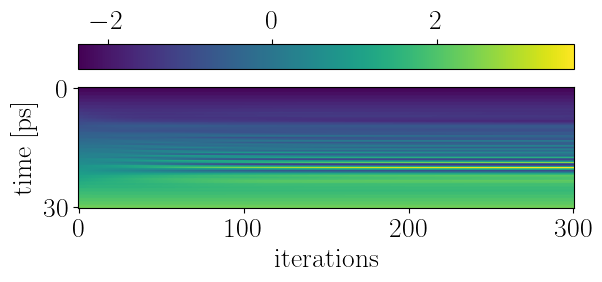

In [14]:
opt_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
N_pulses = len(opt_result.all_pulses)
iters = opt_result.iters
tlist = opt_result.tlist
all_detunings = [opt_result.all_pulses[i][0] for i in range(N_pulses)]
all_envelopes = [opt_result.all_pulses[i][2] for i in range(N_pulses)]
all_envelopes_useless = [opt_result.all_pulses[i][1] for i in range(N_pulses)]
#X = ((iters[i],tlist[i],all_detunings[i]) for i in iters)
plt.imshow(np.asarray(all_detunings).T)
plt.yticks([0,72],[0,30])
plt.ylabel("time [ps]")
plt.xlabel("iterations")
plt.colorbar(orientation="horizontal",location="top",label=r"$\Delta(t)$ [GHz]")
plt.show()

In [31]:
opt_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
system = Ps_system(N_atoms = 1,N_points = 100)
system.init_distribution_MB()
#system.init_distribution_flattop()
system.init_states_ground()
system.create_composite()

detuning = opt_result.optimized_controls[0]
envelope = opt_result.optimized_controls[2]

tlist = opt_result.tlist
laser_guess = {
    "label":"laser",
    "order":0,
    "scale":1000,
    "envelope":envelope,
    "detuning":detuning,
    "unit_wavevector":1,
    "tlist":tlist
}
laser = laser_new(laser_guess)
# plt.plot(laser.tlist,envelope)
# plt.show()
# plt.plot(laser.tlist,detuning)
# plt.show()
system.set_Hamiltonian_MT_general_laser(laser)

velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state
velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(velocity_array) # move all initial velocity states 1 bin to the right
target_states = qt.tensor(target_velocity_states,excited_state).unit() # define target states to be in the excited state

# the probability that a given velocity bin is in the excited state
excited_states = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[system.N_points:system.N_points*2][i]*target_states))[0][0] for i in range(system.N_points)])

t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 0.05 # detuning
lambda_b = 0.1 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(system.H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(system.H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(system.H[3][1]): dict(lambda_a=lambda_b,update_shape=S)}

objective = krotov.Objective(initial_state=system.states, target=target_states, H=system.H)
plt.plot(laser.tlist,[S(t) for t in laser.tlist])
plt.show()
result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
plt.plot(system.velocity_bins,np.asarray(result.expect)[0:system.N_points,0],color="black",ls="dashed")
plt.plot(system.velocity_bins,np.asarray(result.expect)[0:system.N_points,-1],label=r"$P_g$")
plt.plot(system.velocity_bins,np.asarray(result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
plt.legend()
plt.show()

In [32]:
#old_result = krotov.result.Result().load("data/krotov/excitations/excitation_moreFocusOnDetuning.pkl")
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=10,
    #continue_from = old_result,
    store_all_pulses=True    
)

(detuning) lambda_a = 0.05
(rabi0) lambda_b = 0.1
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     3.62e-03    0.00e+00   3.62e-03        n/a        n/a     7
1     3.57e-03    9.27e-06   3.58e-03  -5.03e-05  -4.11e-05    15
2     3.53e-03    7.35e-06   3.53e-03  -4.15e-05  -3.42e-05    14
3     3.49e-03    6.14e-06   3.49e-03  -3.67e-05  -3.06e-05    14
4     3.45e-03    5.33e-06   3.46e-03  -3.39e-05  -2.86e-05    13
5     3.42e-03    4.75e-06   3.43e-03  -3.21e-05  -2.73e-05    14
6     3.39e-03    4.33e-06   3.40e-03  -3.08e-05  -2.64e-05    13
7     3.36e-03    4.00e-06   3.37e-03  -2.97e-05  -2.57e-05    14
8     3.33e-03    3.75e-06   3.34e-03  -2.88e-05  -2.51e-05    14
9     3.31e-03    3.54e-06   3.31e-03  -2.80e-05  -2.45e-05    12
10    3.28e-03    3.36e-06   3.28e-03  -2.73e-05  -2.39e-05    13


In [ ]:
opt_result.dump("data/krotov/excitations/excitation_moreFocusOnDetuning_extendedMB.pkl")
old_result = opt_result